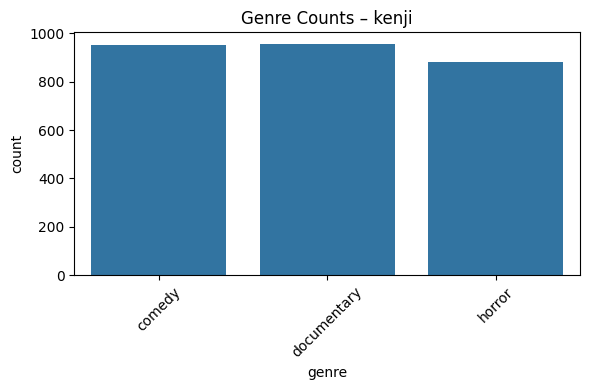

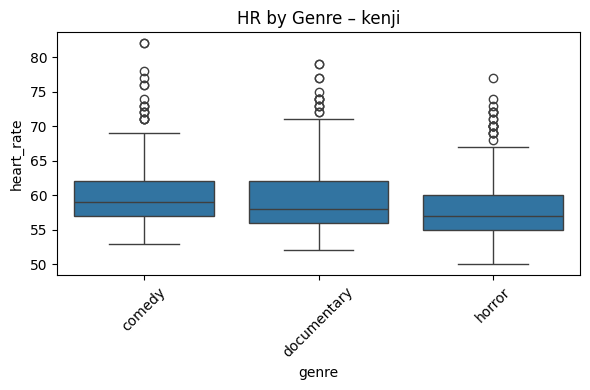

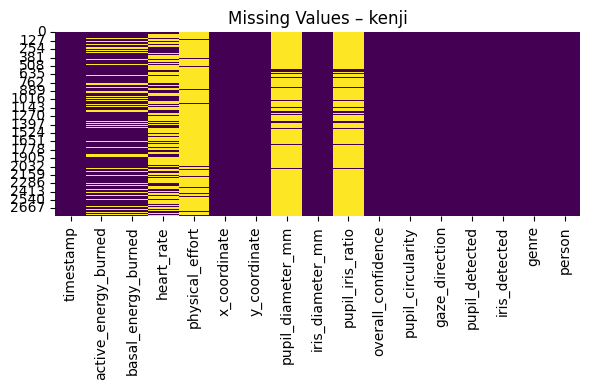

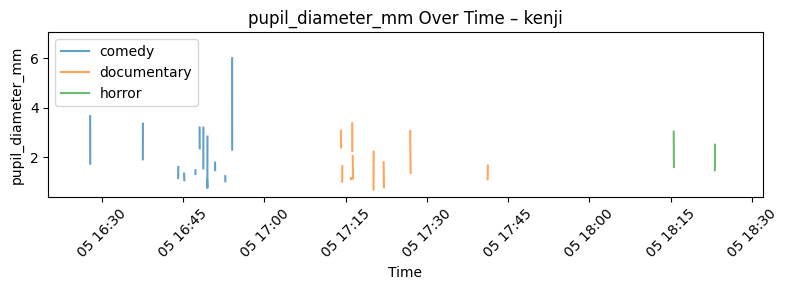

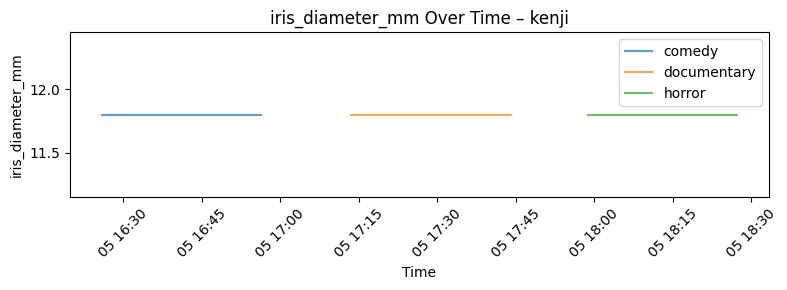

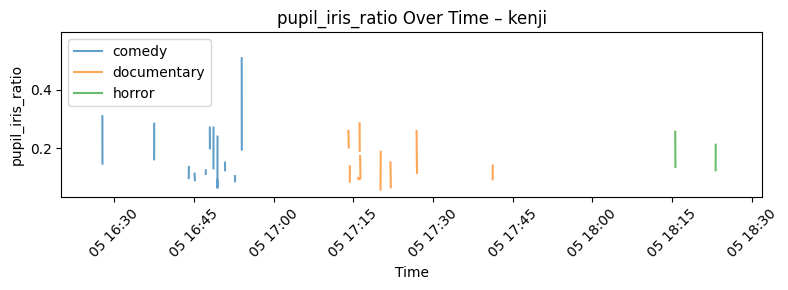

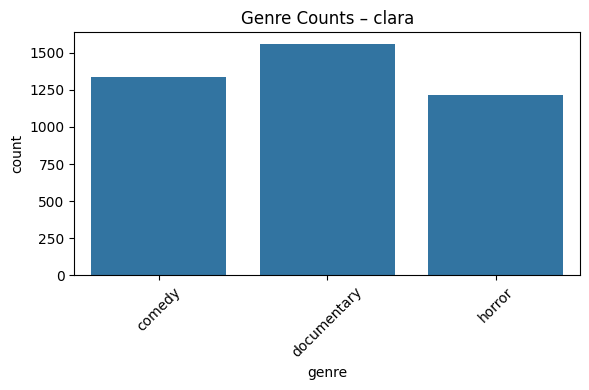

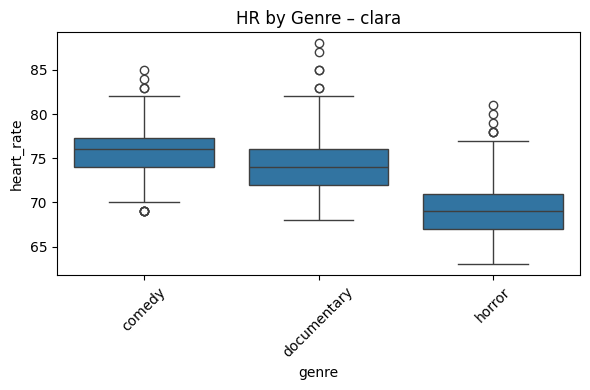

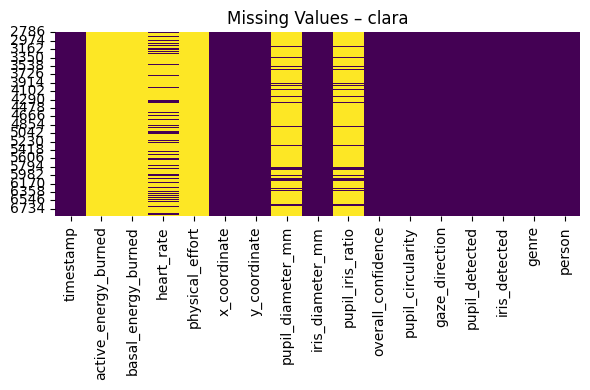

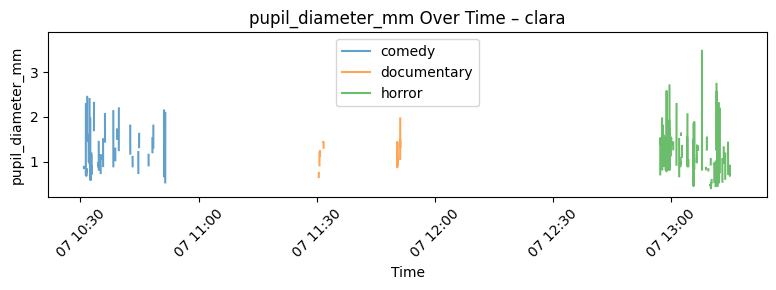

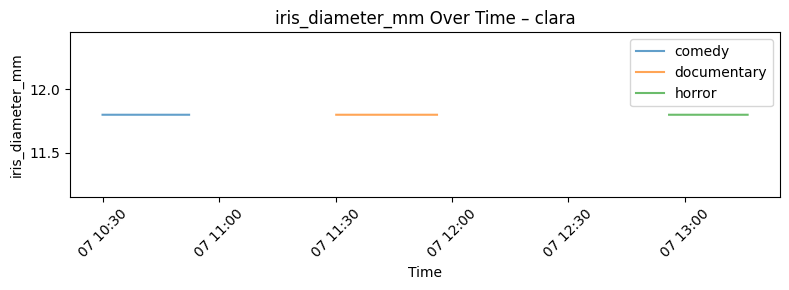

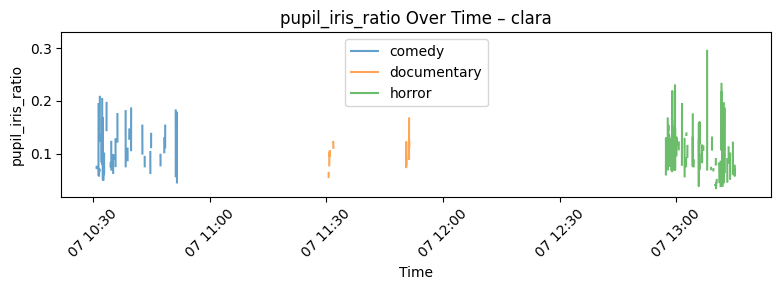

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load datasets
df_kenji = pd.read_csv('../data_collection/generated_data/kenji/all_data.csv')
df_clara = pd.read_csv('../data_collection/generated_data/clara/all_data.csv')

# Tag and combine
df_kenji['person'] = 'kenji'
df_clara['person'] = 'clara'
df = pd.concat([df_kenji, df_clara], ignore_index=True)

# Preprocess
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['pupil_diameter_mm'] = df['pupil_diameter_mm'].replace(0, np.nan)
df['pupil_iris_ratio']  = df['pupil_iris_ratio'].replace(0, np.nan)

# Function to plot for one person
def plot_for_person(sub, person):
    # Genre counts
    plt.figure(figsize=(6,4))
    sns.countplot(x='genre', data=sub)
    plt.title(f'Genre Counts – {person}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Heart rate by genre
    plt.figure(figsize=(6,4))
    sns.boxplot(x='genre', y='heart_rate', data=sub)
    plt.title(f'HR by Genre – {person}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Missing-values heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(sub.isnull(), cbar=False, cmap='viridis')
    plt.title(f'Missing Values – {person}')
    plt.tight_layout()
    plt.show()
    
    # Time-series for pupil metrics
    for col in ['pupil_diameter_mm', 'iris_diameter_mm', 'pupil_iris_ratio']:
        plt.figure(figsize=(8,3))
        for genre in sub['genre'].unique():
            grp = sub[sub['genre']==genre]
            plt.plot(grp['timestamp'], grp[col], label=genre, alpha=0.7)
        plt.title(f'{col} Over Time – {person}')
        plt.xlabel('Time')
        plt.ylabel(col)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Plot for each person
for person in df['person'].unique():
    plot_for_person(df[df['person']==person], person)


### Heart Rate


Clara — HR missing: 80.1% of records


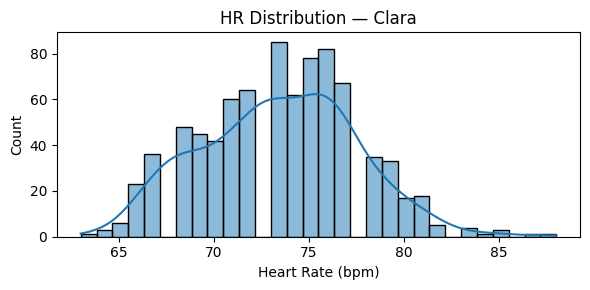

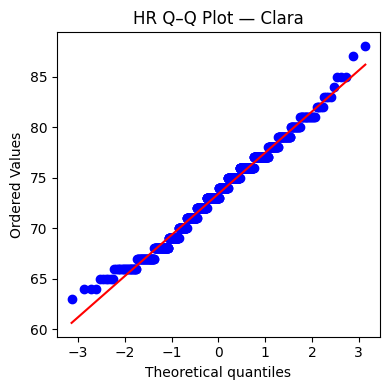


Kenji — HR missing: 61.6% of records


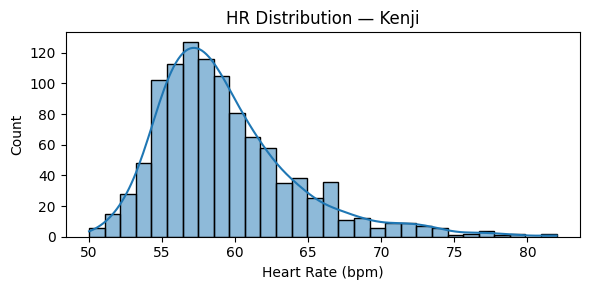

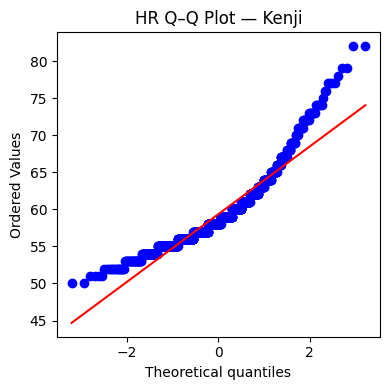

In [2]:
import scipy.stats as stats

# Ensure timestamp sorted
df = df.sort_values('timestamp')

# Function to analyze HR for one person
def analyze_hr_for_person(sub, person):
    hr = sub['heart_rate']
    missing_pct = hr.isna().mean() * 100
    print(f"\n{person.capitalize()} — HR missing: {missing_pct:.1f}% of records")

    # Histogram + KDE
    plt.figure(figsize=(6, 3))
    sns.histplot(hr.dropna(), kde=True, bins=30)
    plt.title(f'HR Distribution — {person.capitalize()}')
    plt.xlabel('Heart Rate (bpm)')
    plt.tight_layout()
    plt.show()

    # Q-Q plot
    plt.figure(figsize=(4, 4))
    stats.probplot(hr.dropna(), dist="norm", plot=plt)
    plt.title(f'HR Q–Q Plot — {person.capitalize()}')
    plt.tight_layout()
    plt.show()

# Apply to each person
for person, sub in df.groupby('person'):
    analyze_hr_for_person(sub, person)


In [54]:
# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Missing HR before cleaning
print("Missing HR before cleaning:", df['heart_rate'].isna().sum())

# 1) Domain-based removal
HR_LOWER_BOUND, HR_UPPER_BOUND = 30, 220
df['heart_rate'] = df['heart_rate'].mask(
    (df['heart_rate'] < HR_LOWER_BOUND) |
    (df['heart_rate'] > HR_UPPER_BOUND)
)

# 2) Jump detection comparing only consecutive non-null HR values
JUMP_THRESHOLD = 10  # bpm

def remove_jumps_nonnull(group):
    group = group.sort_values('timestamp').copy()
    # get series of non-null HR
    hr_nonnull = group['heart_rate'].dropna()
    # compute diffs only between real measurements
    diffs = hr_nonnull.diff().abs()
    # indices where jump > threshold
    outlier_idx = diffs[diffs > JUMP_THRESHOLD].index
    # set those to NaN in the original group
    group.loc[outlier_idx, 'heart_rate'] = np.nan
    return group

# apply per person & genre
df = df.groupby(['person', 'genre'], group_keys=False) \
       .apply(remove_jumps_nonnull)

print("Missing HR after cleaning:", df['heart_rate'].isna().sum())

Missing HR before cleaning: 5012
Missing HR after cleaning: 5019


C:\Users\kenji\AppData\Local\Temp\ipykernel_36952\3994969083.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_jumps_nonnull)


In [ ]:
# --- Local Outlier Factor for HR outlier detection ---
from sklearn.neighbors import LocalOutlierFactor

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Missing HR before cleaning
print("Missing HR before cleaning:", df['heart_rate'].isna().sum())

# 1) Domain-based removal
HR_LOWER_BOUND, HR_UPPER_BOUND = 30, 220
df['heart_rate'] = df['heart_rate'].mask(
    (df['heart_rate'] < HR_LOWER_BOUND) |
    (df['heart_rate'] > HR_UPPER_BOUND)
)

# 1) Keep original HR
df['heart_rate_original'] = df['heart_rate']

# 2) Apply LOF outlier removal, storing cleaned HR in new column
def mark_lof_outliers(group, n_neighbors=5, contamination='auto'):
    group = group.sort_values('timestamp').copy()
    hr = group['heart_rate']
    mask = hr.notna()
    X = hr[mask].values.reshape(-1,1)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    preds = lof.fit_predict(X)
    # mark outliers
    outlier_idx = hr[mask].index[preds == -1]
    group.loc[outlier_idx, 'heart_rate'] = np.nan
    return group

df_clean = df.groupby(['person','genre'], group_keys=False) \
             .apply(mark_lof_outliers)

# 3) Flag removed points
df_clean['hr_removed'] = (
    df_clean['heart_rate_original'].notna() &
    df_clean['heart_rate'].isna()
)

# 4) Plot per person
for person, sub in df_clean.groupby('person'):
    plt.figure(figsize=(12,4))
    # Plot original HR in grey
    plt.plot(sub['timestamp'], sub['heart_rate_original'], color='grey', alpha=0.5, label='Original HR')
    # Plot cleaned HR in blue
    plt.plot(sub['timestamp'], sub['heart_rate'], color='blue', alpha=0.8, label='Cleaned HR')
    # Highlight removed points in red
    removed = sub[sub['hr_removed']]
    plt.scatter(removed['timestamp'], removed['heart_rate_original'], color='red', s=20, label='Removed by LOF')
    
    plt.title(f'Heart Rate Outlier Removal – {person.capitalize()}')
    plt.xlabel('Timestamp')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Missing HR before cleaning: 5012
HR missing after LOF outlier removal: 5079


c:\Users\kenji\OneDrive\Documenten\ML_QuantifiedSelf\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
c:\Users\kenji\OneDrive\Documenten\ML_QuantifiedSelf\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
c:\Users\kenji\OneDrive\Documenten\ML_QuantifiedSelf\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
c:\Users\kenji\OneDrive\Documenten\ML_QuantifiedSelf\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
c:\U